In [1]:
import pandas as pd
import pandasql as pdsql
import seaborn as sns
from matplotlib import pyplot as plt
import scipy 
from sklearn.preprocessing import LabelEncoder
import signac

sns.set_theme(style="whitegrid")

In [2]:
dataset = pd.read_csv("/home/kidrahahjo/Machine-Learning/House Price Regression/Data/train.csv")

In [3]:
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Check for null values per column

In [4]:
columns = list(dataset.columns)
null_vals = []
for column in columns:
    null_check = f"""
        select count(*) as total
        from dataset 
        where "{column}" is null
    """
    count_null = pdsql.sqldf(null_check)
    count_null['label'] = column
    null_vals.append(count_null)
nulls = pd.concat(null_vals)
nulls.reset_index(drop=True, inplace=True)

In [5]:
nulls.head()

,total,label
0,0,Id
1,0,MSSubClass
2,0,MSZoning
3,259,LotFrontage
4,0,LotArea


In [6]:
order_nulls = """
    select label, CAST(total as float) / 1460 * 100 as null_percent
    from nulls 
    where null_percent > 5
    order by total DESC
"""
nulls_final_check = pdsql.sqldf(order_nulls)

<AxesSubplot:xlabel='label', ylabel='null_percent'>

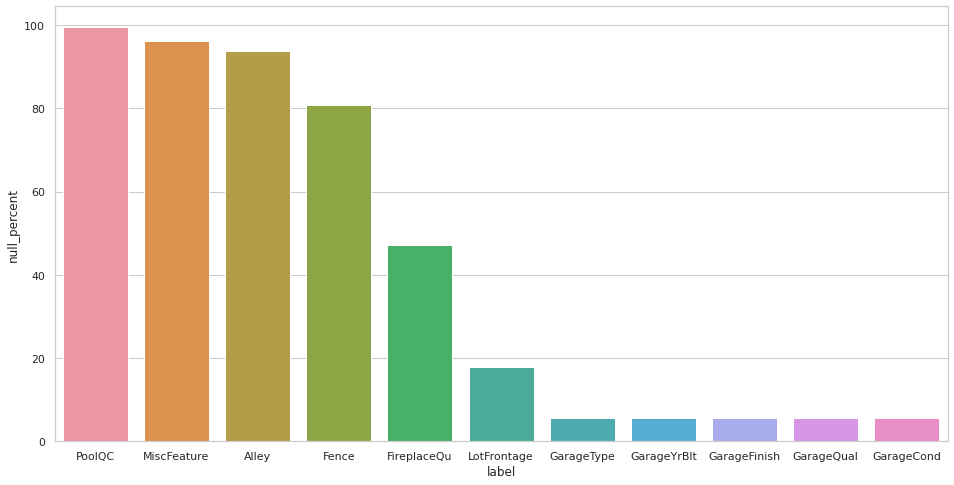

In [7]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(ax=ax, x=nulls_final_check['label'], y=nulls_final_check['null_percent'])

In [8]:
features_to_drop_using_null = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']

In [9]:
dataset = dataset.drop(columns=features_to_drop_using_null)

## FireplaceQu: Fireplace quality
Since we are not very sure how much variation does FireplaceQu explains in the prices, we will calculate R-squared to evaluate this metric
#### Ex
Excellent - Exceptional Masonry Fireplace
#### Gd	
Good - Masonry Fireplace in main level
#### TA
Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
#### Fa
Fair - Prefabricated Fireplace in basement
#### Po
Poor - Ben Franklin Stove
#### No	
No Fireplace

In [10]:
fireplace_query = """
    select distinct FireplaceQu
    from dataset
    where FireplaceQu is not Null
"""
fireplaces = pdsql.sqldf(fireplace_query)

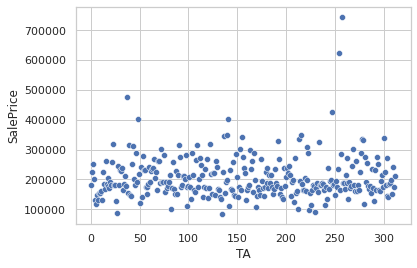

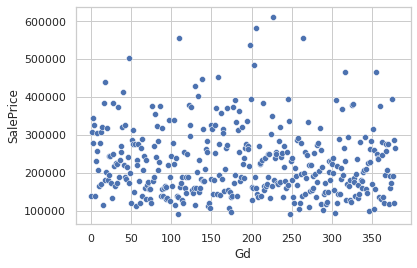

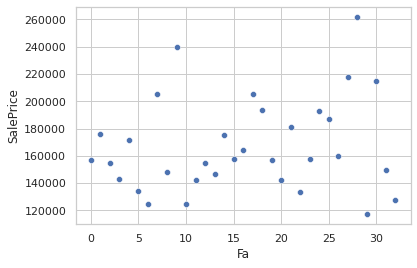

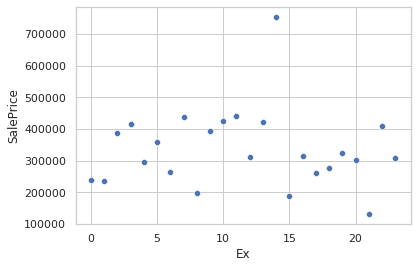

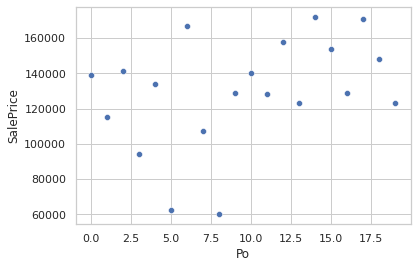

In [11]:
fp_data = []
for i, fireplace in enumerate(list(fireplaces['FireplaceQu'])):
    QUERY = f"""
        select SalePrice 
        from dataset
        where FireplaceQu = "{fireplace}"
    """
    plt.figure()
    fireplace_res = pdsql.sqldf(QUERY)
    fireplace_res['label'] = i
    fireplace_res.reset_index(drop=True, inplace=True)
    fp_data.append(fireplace_res)
    ax = sns.scatterplot(data=fireplace_res['SalePrice'], legend=False)
    ax.set(xlabel=fireplace, ylabel='SalePrice')
fp_datas = pd.concat(fp_data)
fp_datas.reset_index(drop=True, inplace=True)
query = """
    select label, AVG(SalePrice) as average
    from fp_datas
    group by label
"""
fireplace_final = pdsql.sqldf(query)
fireplace_final.to_excel("/home/kidrahahjo/Machine-Learning/House Price Regression/Evaluation Data/FireplaceQu_analysis.xlsx", index=False)

  type  total_nums
0   Ex    1.643836
1   Fa    2.260274
2   Gd   26.027397
3   Po    1.369863
4   TA   21.438356


<AxesSubplot:xlabel='type', ylabel='total_nums'>

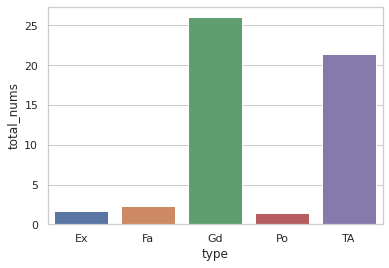

In [12]:
fp_query = """
    select FireplaceQu as type, CAST(count(*) as float) / 1460 * 100 as total_nums
    from dataset
    where FireplaceQu is not Null
    group by FireplaceQu
"""
df = pdsql.sqldf(fp_query)
print(df)
sns.barplot(x="type", y="total_nums", data=df)

I believe these plots help us to come on some conclusive evidence, but in order to be 100% sure that my prediction is correct, I decided to fit a linear regression line for label v/s Average price and I got the R squared to be equals 0.007. Which means the `FireplaceQu` feature explains only 0.7 % variance in the price which is very low. Hence I decide to drop this feature.

In [13]:
dataset = dataset.drop(columns=['FireplaceQu'])

## Cleaning with respect to R-squared

In [14]:
def rsquared(x, Y):
    """ Return R^2 where x and y are array-like."""
    if str(x.dtype) == 'object':
        col = x.name
        labelencoder = LabelEncoder()
        x = labelencoder.fit_transform(x)
        x = pd.Series(x)
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, Y)
    return r_value**2

rsquared_testing = {"label": [], "rsquared": []}

for col in dataset:
    if col == "SalePrice":
        continue
    query = f"""
        select "{col}" as col, SalePrice
        from dataset
        where "{col}" is not Null
    """
    df = pdsql.sqldf(query)
    rs = rsquared(df['col'], df['SalePrice'])
    rsquared_testing["label"].append(col)
    rsquared_testing["rsquared"].append(rs)

rsquared_df = pd.DataFrame(rsquared_testing)

In [26]:
QUERY = """
    select label, rsquared * 100 as percentage_var
    from rsquared_df
    where rsquared is not Null and percentage_var > 10
    order by 2 DESC
"""
rsquared_non_cat = pdsql.sqldf(QUERY)
rsquared_non_cat

,label,percentage_var
0,OverallQual,62.565189
1,GrLivArea,50.214865
2,GarageCars,41.012394
3,ExterQual,40.562084
4,GarageArea,38.866676
5,TotalBsmtSF,37.648109
6,BsmtQual,37.353938
7,1stFlrSF,36.705687
8,KitchenQual,34.714342
9,FullBath,31.434385


In [27]:
features = list(rsquared_non_cat['label']) + ['SalePrice']

In [28]:
final_dataset = dataset[features] 

In [18]:
project = signac.init_project('dataset_per_rsquared')

In [29]:
project.open_job({'10%': features}).init()

Job(project=Project.get_project('/home/kidrahahjo/Machine-Learning/House Price Regression'), statepoint={'10%': ['OverallQual', 'GrLivArea', 'GarageCars', 'ExterQual', 'GarageArea', 'TotalBsmtSF', 'BsmtQual', '1stFlrSF', 'KitchenQual', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'GarageFinish', 'YearRemodAdd', 'GarageYrBlt', 'MasVnrArea', 'Fireplaces', 'HeatingQC', 'BsmtFinSF1', 'Foundation', 'GarageType', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'SalePrice']})

In [30]:
final_dataset.to_csv("/home/kidrahahjo/Machine-Learning/House Price Regression/10rsq_final_data.csv", index=False)